In [1]:
import pandas as pd
from pandas import read_excel
import re
from re import sub
import matplotlib.pyplot as plt



In [2]:


# Load the dataset
file_path = "/content/Dataset-Sentiment Analysis (Task-ML Engineer).xlsx"
dataset = pd.read_excel(file_path)

# Check the distribution of labels
label_distribution = dataset['sentiment'].value_counts()
print(label_distribution)


sentiment
neutral     45
negative    42
positive    12
Name: count, dtype: int64


This shows a significant imbalance, with the "Positive" class being underrepresented compared to "Neutral" and "Negative." In this case we need to  consider techniques like oversampling, undersampling, or using algorithms that handle imbalanced datasets to improve the model’s performance on the minority class.

In [3]:
dataset['Text_Length'] = dataset['conversation_text'].apply(lambda x: len(str(x)))

# Get summary statistics for the text lengths
text_length_stats = dataset['conversation_text'].describe()
print(text_length_stats)

count                                                    99
unique                                                   89
top       বিজনেস স্ট্যান্ডার্ডের খবরে দেখলাম, bank_y ব্য...
freq                                                      3
Name: conversation_text, dtype: object


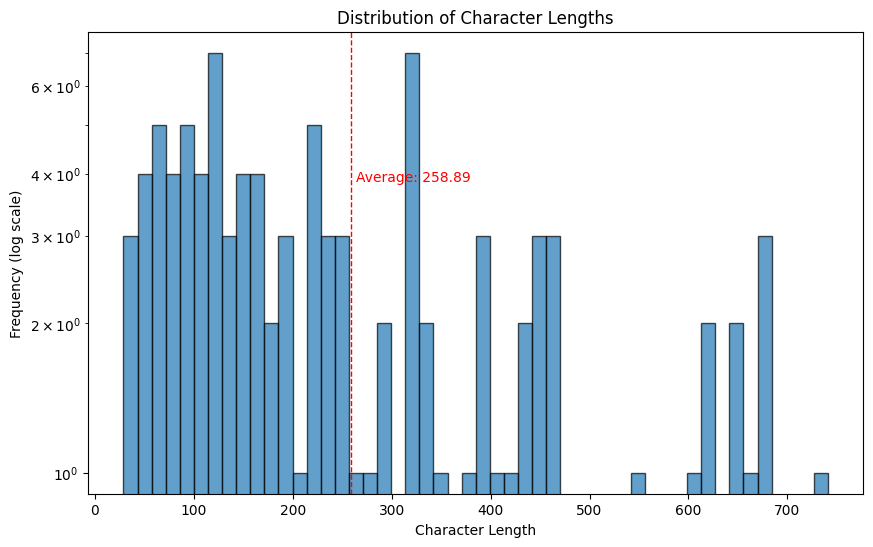

In [4]:
#Calculate the length of each text entry in characters
dataset['Char_Length'] = dataset['conversation_text'].apply(len)

#Plot a histogram with more bins and a log scale
plt.figure(figsize=(10, 6))
plt.hist(dataset['Char_Length'], bins=50, edgecolor='k', alpha=0.7)
plt.yscale('log')

#Calculate and display the average character length
average_char_length = dataset['Char_Length'].mean()
plt.axvline(average_char_length, color='r', linestyle='dashed', linewidth=1)
plt.text(average_char_length + 5, plt.ylim()[1] / 2, f'Average: {average_char_length:.2f}', color='r')

plt.xlabel('Character Length')
plt.ylabel('Frequency (log scale)')
plt.title('Distribution of Character Lengths')


plt.show()


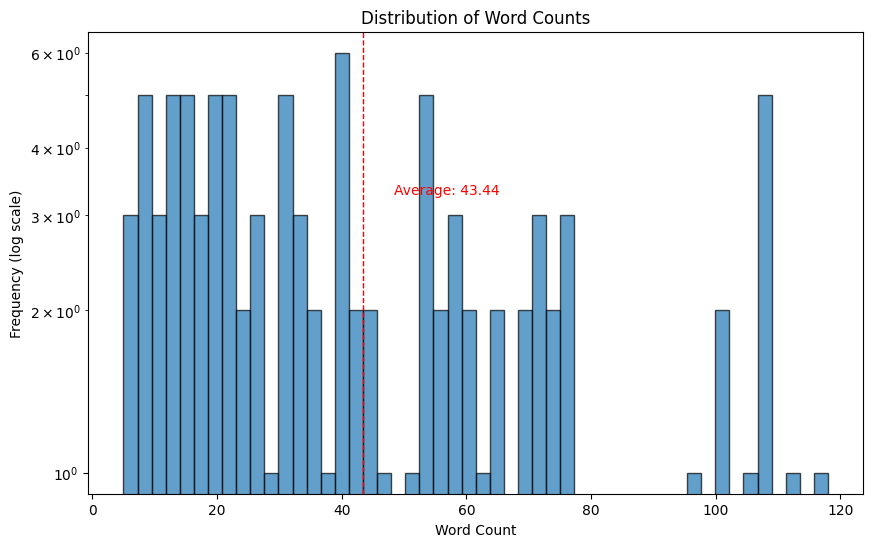

In [5]:



dataset['Word_Count'] = dataset['conversation_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
plt.hist(dataset['Word_Count'], bins=50, edgecolor='k', alpha=0.7)
plt.yscale('log')

average_word_count = dataset['Word_Count'].mean()
plt.axvline(average_word_count, color='r', linestyle='dashed', linewidth=1)
plt.text(average_word_count + 5, plt.ylim()[1] / 2, f'Average: {average_word_count:.2f}', color='r')  # Adjusted text position for log scale

plt.xlabel('Word Count')
plt.ylabel('Frequency (log scale)')
plt.title('Distribution of Word Counts')


plt.show()


In [6]:


# Load the dataset
file_path = "/content/Dataset-Sentiment Analysis (Task-ML Engineer).xlsx"
dataset = pd.read_excel(file_path)

# Function to check if a word is Bangla or Banglish
def count_bangla_banglish(text):
    bangla_count = 0
    banglish_count = 0

    # Tokenize words
    words = str(text).split()

    # Check each word's script
    for word in words:
        if re.search(r'[\u0980-\u09FF]', word):  # Bengali script range
            bangla_count += 1
        elif re.search(r'[a-zA-Z]', word):  # Latin characters
            banglish_count += 1

    return bangla_count, banglish_count


dataset[['Bangla_Count', 'Banglish_Count']] = dataset['conversation_text'].apply(lambda x: pd.Series(count_bangla_banglish(x)))


total_bangla = dataset['Bangla_Count'].sum()
total_banglish = dataset['Banglish_Count'].sum()

# Calculate ratio of Bangla to Banglish
ratio_bangla_banglish = total_bangla / total_banglish if total_banglish != 0 else float('inf')


print(f"Total Bangla words: {total_bangla}")
print(f"Total Banglish words: {total_banglish}")
print(f"Ratio of Bangla to Banglish words: {ratio_bangla_banglish:.2f}")


Total Bangla words: 3806
Total Banglish words: 434
Ratio of Bangla to Banglish words: 8.77


In [7]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 5.5 MB/s eta 0:00:00


In [8]:

import emoji
from collections import Counter


file_path = "/content/Dataset-Sentiment Analysis (Task-ML Engineer).xlsx"
dataset = pd.read_excel(file_path)

# Function to extract emojis from text
def extract_emojis(text):
    return ''.join(char for char in text if char in emoji.EMOJI_DATA)

# Extract emojis and count their frequency
dataset['Emojis'] = dataset['conversation_text'].apply(extract_emojis)
all_emojis = ''.join(dataset['Emojis'])
emoji_count = Counter(all_emojis)

# Display the frequency of each emoji
print(emoji_count)


Counter({'🙏': 6, '📵': 4, '🤔': 3, '❤': 2, '☑': 2, '🥺': 1, '🙂': 1, '➖': 1, '😴': 1})


In [16]:
import numpy as np
import pandas as pd
from gensim.models import KeyedVectors
import os
from gensim.models.fasttext import load_facebook_vectors

fasttext_url = "https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.bn.300.bin.gz"
fasttext_model_path = "/content/cc.bn.300.bin"
compressed_model_path = "cc.bn.300.bin.gz"

def download_and_extract_fasttext_model():
    import urllib.request
    import gzip
    import shutil


    if not os.path.exists(compressed_model_path):
        print("Downloading the Bangla FastText model...")
        # Download the compressed FastText model
        urllib.request.urlretrieve(fasttext_url, compressed_model_path)
        print("Download completed.")

    # Unzip the downloaded file if the .bin file doesn't exist
    try:
        print("Extracting the FastText model...")
        with gzip.open(compressed_model_path, 'rb') as f_in:
            with open(fasttext_model_path, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
        print("Model extracted.")
    except EOFError:
        # If there's an error during extraction, delete the corrupted file and retry
        print("Error: Corrupted compressed file. Re-downloading...")
        os.remove(compressed_model_path)
        download_and_extract_fasttext_model()

# Check if the FastText model already exists; if not, download and unzip it
if not os.path.exists(fasttext_model_path):
    download_and_extract_fasttext_model()

# Load the pre-trained FastText model in binary format
print("Loading the FastText model...")

ft_model = load_facebook_vectors(fasttext_model_path)
# Load your dataset
file_path = "/content/Dataset-Sentiment Analysis (Task-ML Engineer).xlsx"
dataset = pd.read_excel(file_path)

# Function to get FastText embeddings for a sentence
def get_sentence_embedding(sentence):
    words = sentence.split()
    word_embeddings = [ft_model[word] for word in words if word in ft_model]
    if len(word_embeddings) > 0:
        return np.mean(word_embeddings, axis=0)  # Average of word vectors
    else:
        return np.zeros(ft_model.vector_size)  # Return zero vector if no words found in FastText

# Apply tokenization and embedding extraction to the processed text column
dataset['fasttext_embedding'] = dataset['conversation_text'].apply(get_sentence_embedding)

# Show a preview of the dataset with the FastText embeddings
print(dataset[['conversation_text', 'fasttext_embedding']].head())


Loading the FastText model...


                                   conversation_text  \
0  company_x এজেন্ট থেকে রং নাম্বারে টাকা গেলে ফে...   
1  company_x গ্রাহকদের জন্য খুবই দুঃখ জনক একটা খব...   
2  company_x গ্রাহকদের জন্য খুবই দুঃখ জনক একটা খব...   
3  bank_y ব্যাংক যখন ঘোষনা দিয়েছে যে কার্ড দিয়ে ক...   
4  bank_y ব্যাংক যখন ঘোষনা দিয়েছে যে কার্ড দিয়ে ক...   

                                  fasttext_embedding  
0  [-0.005784124, 0.014674448, 0.026405144, 0.003...  
1  [-0.009694216, 0.0039162487, 0.022406045, 0.01...  
2  [-0.00973235, 0.004798463, 0.025176251, 0.0159...  
3  [0.0075694057, -0.0077172336, 0.014165492, 0.0...  
4  [0.0075694057, -0.0077172336, 0.014165492, 0.0...  



Classification Report for SVM:

              precision    recall  f1-score   support

    negative       0.45      0.83      0.59         6
     neutral       0.78      0.64      0.70        11
    positive       0.00      0.00      0.00         3

    accuracy                           0.60        20
   macro avg       0.41      0.49      0.43        20
weighted avg       0.56      0.60      0.56        20


Classification Report for Logistic Regression:

              precision    recall  f1-score   support

    negative       0.33      0.83      0.48         6
     neutral       0.60      0.27      0.37        11
    positive       0.00      0.00      0.00         3

    accuracy                           0.40        20
   macro avg       0.31      0.37      0.28        20
weighted avg       0.43      0.40      0.35        20


Classification Report for Decision Tree:

              precision    recall  f1-score   support

    negative       0.33      0.83      0.48         6
    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif


Classification Report for Random Forest:

              precision    recall  f1-score   support

    negative       0.44      0.67      0.53         6
     neutral       0.73      0.73      0.73        11
    positive       0.00      0.00      0.00         3

    accuracy                           0.60        20
   macro avg       0.39      0.46      0.42        20
weighted avg       0.53      0.60      0.56        20


Classification Report for KNN:

              precision    recall  f1-score   support

    negative       0.40      1.00      0.57         6
     neutral       1.00      0.36      0.53        11
    positive       1.00      0.33      0.50         3

    accuracy                           0.55        20
   macro avg       0.80      0.57      0.53        20
weighted avg       0.82      0.55      0.54        20


Classification Report for Naive Bayes:

              precision    recall  f1-score   support

    negative       0.33      0.67      0.44         6
     neutral

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


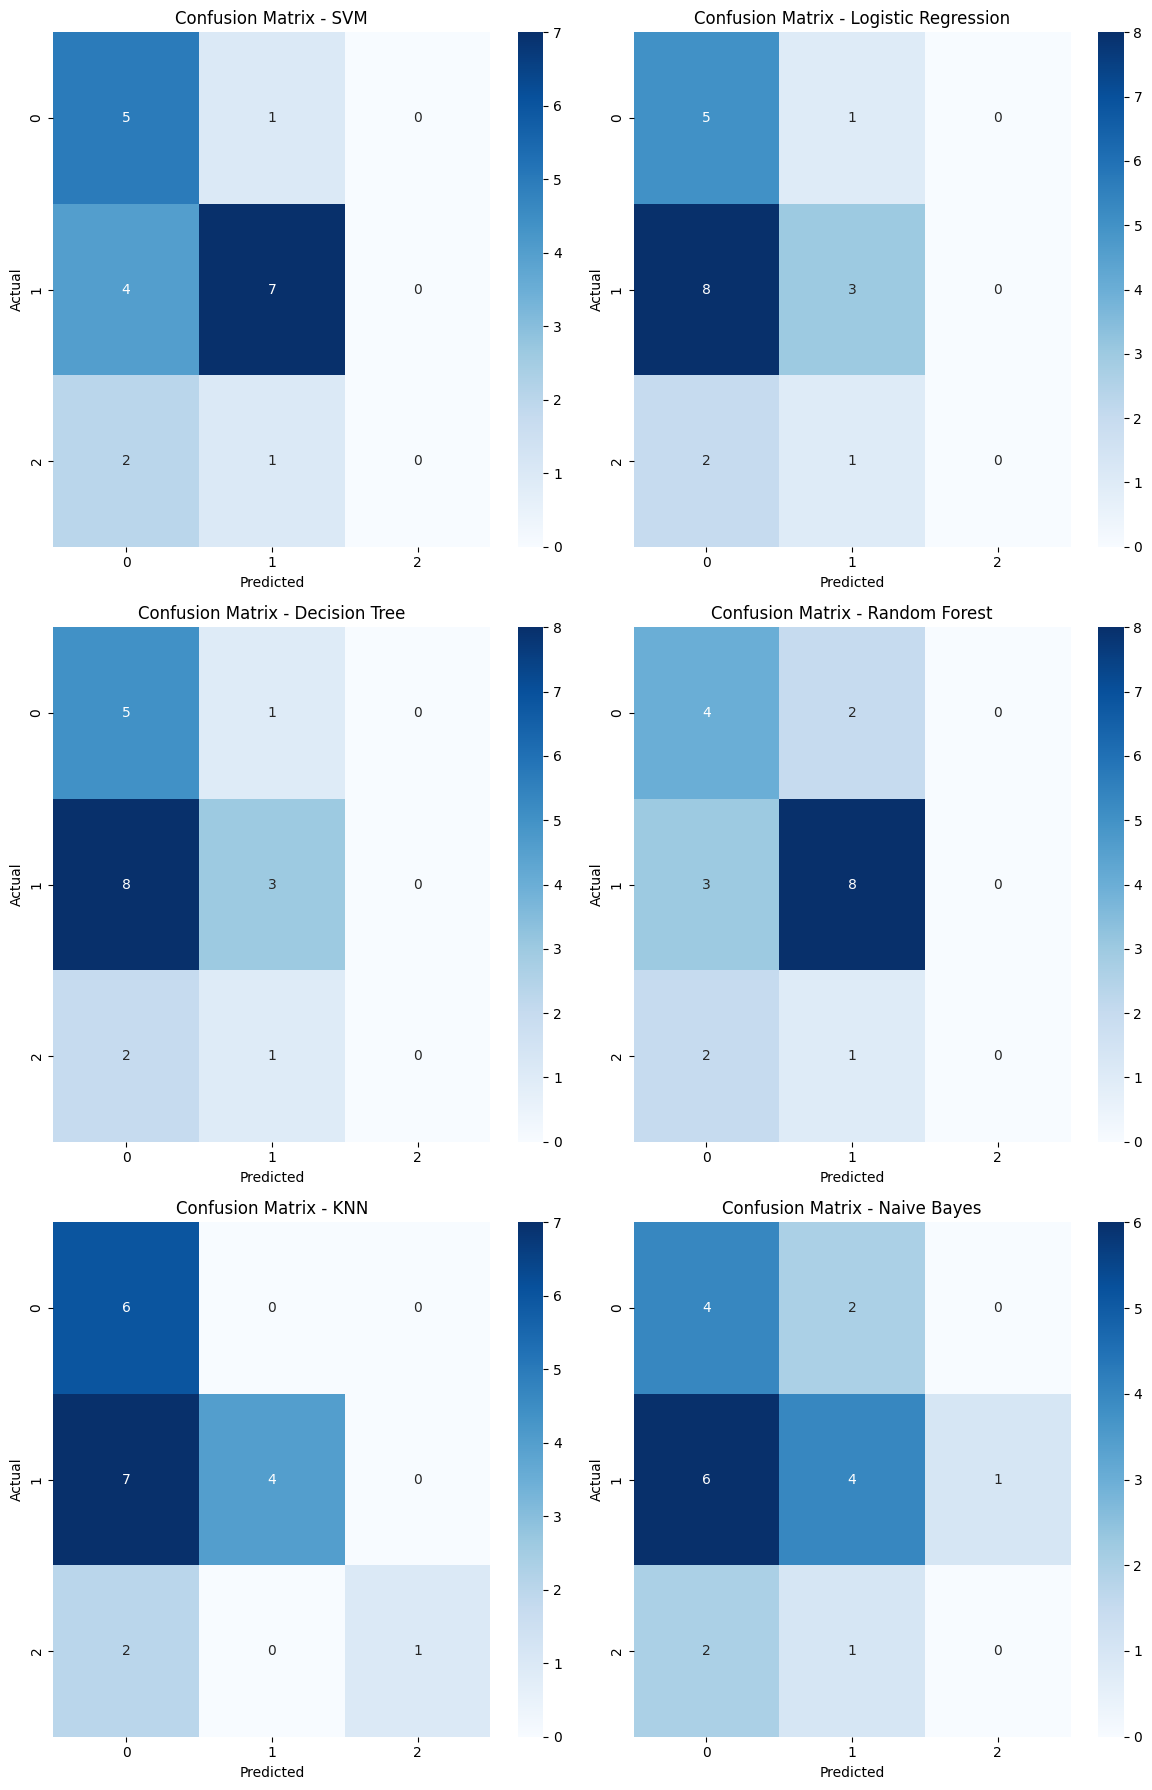

                 Model  Accuracy  F1 Score  Recall
0                  SVM      0.60  0.561471    0.60
1  Logistic Regression      0.40  0.349107    0.40
2        Decision Tree      0.40  0.349107    0.40
3        Random Forest      0.60  0.560000    0.60
4                  KNN      0.55  0.539762    0.55
5          Naive Bayes      0.40  0.377778    0.40


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns



# 1. Preprocessing - Extract features (fasttext_embedding) and target
X = np.vstack(dataset['fasttext_embedding'].values)
y = dataset['sentiment'].values

# 2. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Define models
models = {
    "SVM": SVC(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB()
}

# 4. Train and Evaluate Models
results = {}

for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)

    # Store the results
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'f1_score': f1,
        'recall': recall,
        'confusion_matrix': cm
    }

    # Print classification report for each model
    print(f"\nClassification Report for {name}:\n")
    print(classification_report(y_test, y_pred))
# 5. Plot Confusion Matrices and Compare Metrics
num_models = len(results)
rows = (num_models + 1) // 2  # This calculates how many rows are needed to fit the models

fig, axes = plt.subplots(rows, 2, figsize=(12, 6 * rows))  # Adjust figure size based on the number of rows
axes = axes.flatten()  # Flatten the axes array in case we have more than 1 row

for idx, (name, result) in enumerate(results.items()):
    sns.heatmap(result['confusion_matrix'], annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(f"Confusion Matrix - {name}")
    axes[idx].set_xlabel("Predicted")
    axes[idx].set_ylabel("Actual")

# Remove any unused axes
for ax in axes[len(results):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

# 6. Print comparison of metrics (Accuracy, F1 Score, Recall)
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[model]['accuracy'] for model in results],
    'F1 Score': [results[model]['f1_score'] for model in results],
    'Recall': [results[model]['recall'] for model in results]
})

# Display comparison dataframe
print(comparison_df)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training CNN model...
Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.3511 - loss: 1.0995 - val_accuracy: 0.5000 - val_loss: 1.0837
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.4923 - loss: 1.0615 - val_accuracy: 0.5000 - val_loss: 1.0673
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4850 - loss: 0.9877 - val_accuracy: 0.3750 - val_loss: 1.0913
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5061 - loss: 0.9945 - val_accuracy: 0.3750 - val_loss: 1.1253
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4769 - loss: 0.9769 - val_accuracy: 0.2500 - val_loss: 1.1198


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report for CNN:

              precision    recall  f1-score   support

    negative       0.30      1.00      0.46         6
     neutral       0.00      0.00      0.00        11
    positive       0.00      0.00      0.00         3

    accuracy                           0.30        20
   macro avg       0.10      0.33      0.15        20
weighted avg       0.09      0.30      0.14        20

Training LSTM model...
Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.3786 - loss: 1.0970 - val_accuracy: 0.5000 - val_loss: 1.0942
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.4725 - loss: 1.0862 - val_accuracy: 0.3750 - val_loss: 1.0899
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.4738 - loss: 1.0692 - val_accuracy: 0.3750 - val_loss: 1.0859


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step

Classification Report for LSTM:

              precision    recall  f1-score   support

    negative       0.30      1.00      0.46         6
     neutral       0.00      0.00      0.00        11
    positive       0.00      0.00      0.00         3

    accuracy                           0.30        20
   macro avg       0.10      0.33      0.15        20
weighted avg       0.09      0.30      0.14        20

Training RNN model...
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.2965 - loss: 1.0886 - val_accuracy: 0.2500 - val_loss: 1.1063
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.3391 - loss: 1.1425 - val_accuracy: 0.3750 - val_loss: 1.0943
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.4650 - loss: 1.0579 - val_accuracy: 0.3750 - val_loss: 1.0974
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step

Classification Report for RNN:

              precision    recall  f1-score   support

    negative       0.31      0.67      0.42         6
     neutral       0.43      0.27      0.33        11
    positive       0.00      0.00      0.00         3

    accuracy                           0.35        20
   macro avg       0.25      0.31      0.25        20
weighted avg       0.33      0.35      0.31        20

Training BiLSTM model...
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 190ms/step - accuracy: 0.2990 - loss: 1.0972 - val_accuracy: 0.2500 - val_loss: 1.0957
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.4358 - loss: 1.0838 - val_accuracy: 0.2500 - val_loss: 1.0930
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.5237 - loss: 1.0589 - val_accuracy: 0.2500 - val_loss: 1.0945
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step

Classification Report for BiLSTM:

              precision    recall  f1-score   support

    negative       0.30      1.00      0.46         6
     neutral       0.00      0.00      0.00        11
    positive       0.00      0.00      0.00         3

    accuracy                           0.30        20
   macro avg       0.10      0.33      0.15        20
weighted avg       0.09      0.30      0.14        20



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


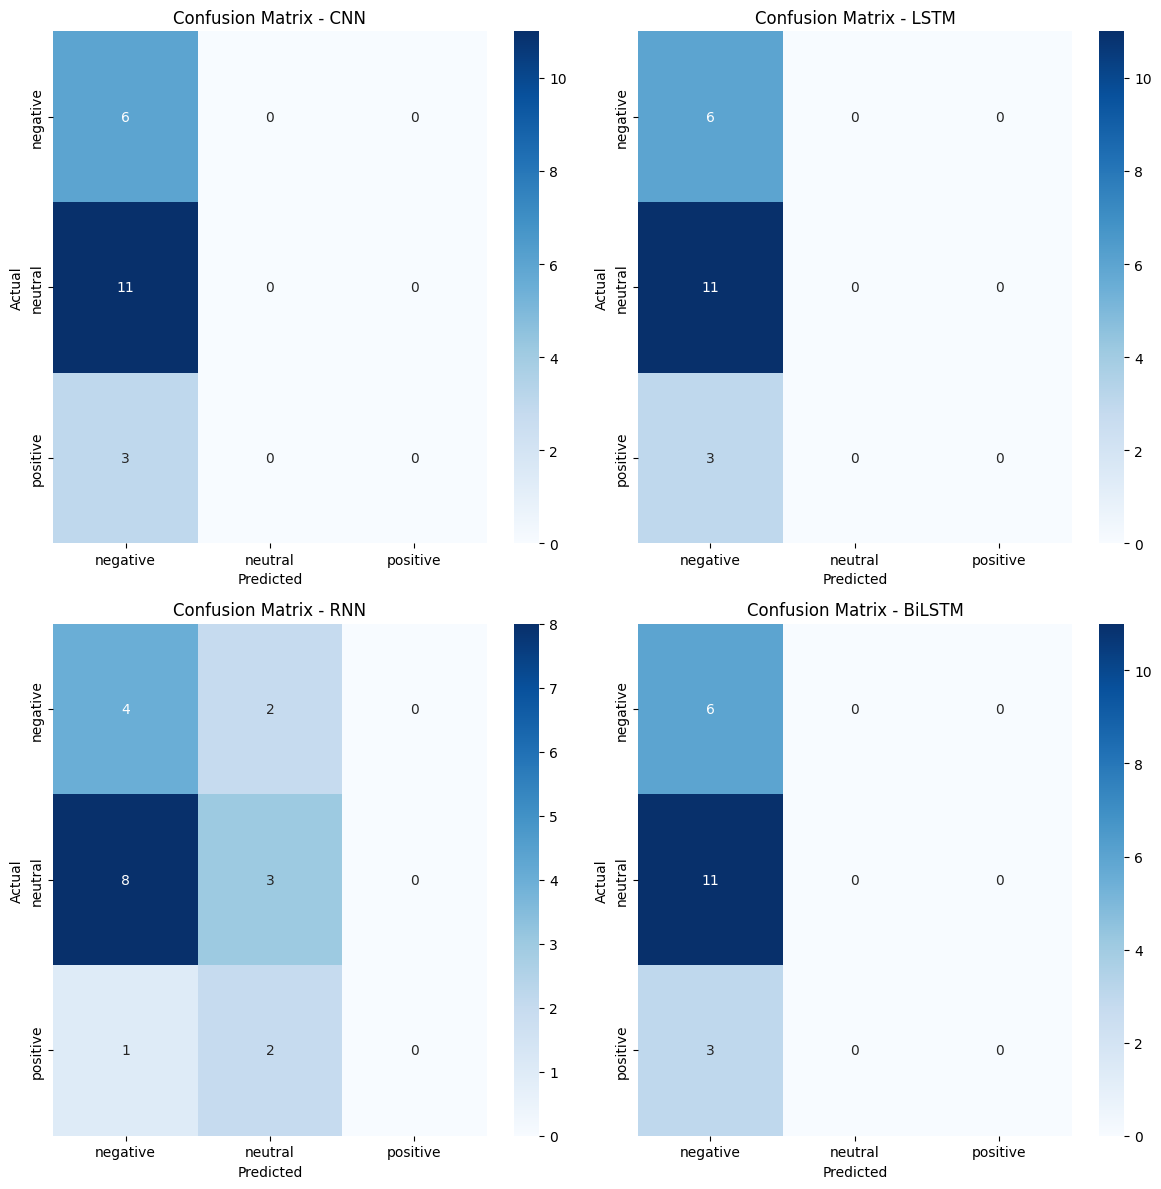

    Model  Accuracy  F1 Score  Recall
0     CNN      0.30  0.138462    0.30
1    LSTM      0.30  0.138462    0.30
2     RNN      0.35  0.309649    0.35
3  BiLSTM      0.30  0.138462    0.30


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, recall_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, LSTM, SimpleRNN, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical


#Extract features using Fasttext
X = np.vstack(dataset['fasttext_embedding'].values)
y = dataset['sentiment'].values

# Encode the labels as integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


y_onehot = to_categorical(y_encoded, num_classes=3)

# Reshaping data
X = X.reshape((X.shape[0], X.shape[1], 1))

#Train-Test Split 80-20
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)

#Define Models (CNN, LSTM, RNN, BiLSTM)

def create_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))  #  filters
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))  # dense layer size
    model.add(Dropout(0.5))  # Dropout to prevent overfitting
    model.add(Dense(3, activation='softmax'))  # softmax for multiclass classification
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(32, input_shape=input_shape))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))  # Dropout layer
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def create_rnn_model(input_shape):
    model = Sequential()
    model.add(SimpleRNN(32, input_shape=input_shape))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))  # Dropout layer
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def create_bilstm_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(32), input_shape=input_shape))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))  # Dropout layer
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Input shape for models (number of features, 1)
input_shape = (X_train.shape[1], 1)

# Define the models
models = {
    "CNN": create_cnn_model(input_shape),
    "LSTM": create_lstm_model(input_shape),
    "RNN": create_rnn_model(input_shape),
    "BiLSTM": create_bilstm_model(input_shape)
}

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

results = {}

for name, model in models.items():
    print(f"Training {name} model...")
    # Train the model
    model.fit(X_train, y_train, epochs=10, batch_size=8, validation_split=0.1, callbacks=[early_stopping], verbose=1)  # Low batch size for small dataset

    # Make predictions
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_test_labels = np.argmax(y_test, axis=1)

    # Inverse transform the numerical labels back to sentiment labels
    y_pred_labels = label_encoder.inverse_transform(y_pred)
    y_test_true_labels = label_encoder.inverse_transform(y_test_labels)

    # Calculate metrics
    accuracy = accuracy_score(y_test_true_labels, y_pred_labels)
    f1 = f1_score(y_test_true_labels, y_pred_labels, average='weighted')
    recall = recall_score(y_test_true_labels, y_pred_labels, average='weighted')
    cm = confusion_matrix(y_test_true_labels, y_pred_labels, labels=label_encoder.classes_)

    # Store the results
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'f1_score': f1,
        'recall': recall,
        'confusion_matrix': cm
    }

    # Print classification report for each model
    print(f"\nClassification Report for {name}:\n")
    print(classification_report(y_test_true_labels, y_pred_labels, target_names=label_encoder.classes_))

# Plot Confusion Matrices
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for idx, (name, result) in enumerate(results.items()):
    sns.heatmap(result['confusion_matrix'], annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    axes[idx].set_title(f"Confusion Matrix - {name}")
    axes[idx].set_xlabel("Predicted")
    axes[idx].set_ylabel("Actual")

plt.tight_layout()
plt.show()


comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[model]['accuracy'] for model in results],
    'F1 Score': [results[model]['f1_score'] for model in results],
    'Recall': [results[model]['recall'] for model in results]
})

print(comparison_df)
